In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/5779.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/792.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/3393.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/6309.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/4493.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/5881.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/556.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/380.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/6696.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/7142.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/2563.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/1111.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/4705.tif
/kaggle/input/weed-detection-in-soybean-crops/dataset/soybean/5672.tif
/kaggle/i

## Image Classification On Weed Detection in Soybean Crop 

In [2]:
# Libraries for the Project 
import numpy as np     # Scientific Calculations 
import pandas as pd    # for Data Manupulation 
import seaborn as sns  #  for Visualization 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt # for visualization 

## Pytorch Librabires for the Modelling and related stuff

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import time
import os
from torch.optim.lr_scheduler import _LRScheduler

We set the random seed so all of our experiments car be reproduced.

In [3]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
%matplotlib inline
sns.set_style('darkgrid')

The data set is loadead form the directory (kaggle)

In [5]:
root_dir = "../input/weed-detection-in-soybean-crops/dataset/dataset"
print("The data lies here =>", root_dir)

The data lies here => ../input/weed-detection-in-soybean-crops/dataset/dataset


In [6]:
dataset = torchvision.datasets.ImageFolder(root_dir)

<br>Standard mean and standard deviation from imagenet pertained model is used for normaliztion because standard mean and std produces good results.

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

Data augementation and normalization is applied to the dataset.

In [8]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
}

In [9]:
weed_img_dataset = datasets.ImageFolder(
                              root = root_dir,
                              transform = image_transforms["train"]
                       )
weed_img_dataset

Dataset ImageFolder
    Number of datapoints: 15336
    Root location: ../input/weed-detection-in-soybean-crops/dataset/dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Categories of the classes avaliable 

In [10]:
weed_img_dataset.class_to_idx

{'broadleaf': 0, 'grass': 1, 'soil': 2, 'soybean': 3}

In [11]:
idx2class = {v: k for k, v in weed_img_dataset.class_to_idx.items()}
idx2class

{0: 'broadleaf', 1: 'grass', 2: 'soil', 3: 'soybean'}

#### Show the frequency for each class in the dataset

In [12]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict
print("Distribution of classes: \n", get_class_distribution(weed_img_dataset))

Distribution of classes: 
 {'broadleaf': 1191, 'grass': 3520, 'soil': 3249, 'soybean': 7376}


Text(0.5, 1.0, 'Weed Detection in Soybean')

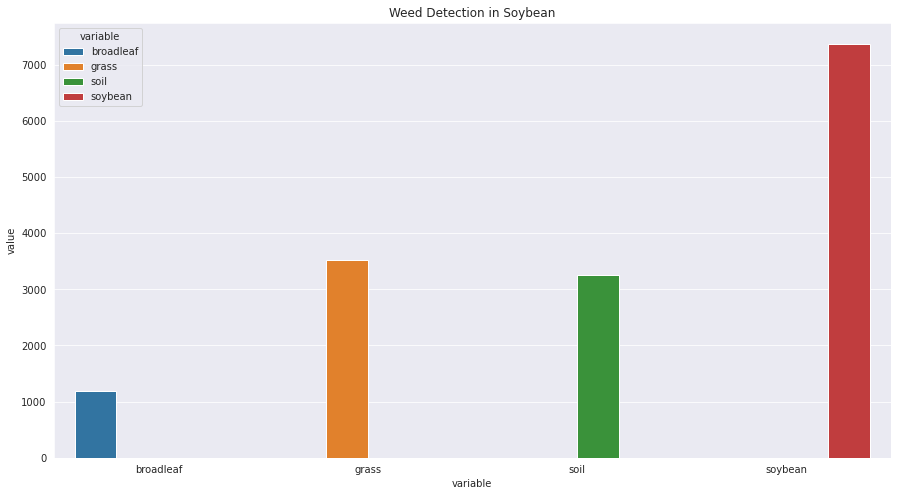

In [13]:
plt.figure(figsize=(15,8))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(weed_img_dataset)]).melt(), x = "variable", y="value", hue="variable").set_title('Weed Detection in Soybean')

#### Train-validation split: 80% training, 20% validation 

In [14]:
train_dataset, val_dataset = random_split(weed_img_dataset, (12268, 3068))

In [15]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(val_dataset)}')

Number of training examples: 12268
Number of validation examples: 3068


In [16]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [17]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_dataset[i] for i in range(N_IMAGES)]])

classes = idx2class

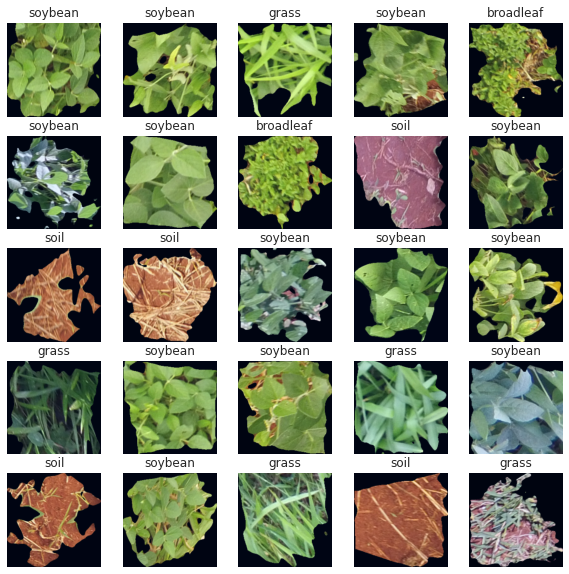

In [18]:
plot_images(images, labels, classes, normalize = True)

#### Weighted Random Sampler to provide distributed random smaples to avoid overfitting 

In [19]:
BATCH_SIZE = 64
weights = 1 / torch.Tensor(list(get_class_distribution(weed_img_dataset).values()))
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, BATCH_SIZE)


In [20]:
train_iterator = DataLoader(dataset=train_dataset,  
                                 batch_size = BATCH_SIZE, sampler = sampler)

valid_iterator = DataLoader(dataset=val_dataset, 
                                 batch_size = BATCH_SIZE, sampler = sampler)

## The model 

In [21]:
class myNet(nn.Module):
    def __init__(self, output_dim=4):
        super().__init__()
        kernel_size = 3
        out_ch = 150
        n_targets = output_dim
        
        self.features =  nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                      nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2), # size reduction 1/2, 32->16
                      nn.Dropout(0.2),

                      nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                      nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                      nn.ReLU(),
                      nn.Dropout(0.2),

                      nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                      nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2), # size reduction 1/2; 16 -> 8
                      nn.Dropout(0.2),

                      nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                      nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2), # size reduction 1/2; 8 -> 4
                      nn.Dropout(0.2),

                      nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                      nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                      nn.ReLU(),
                      nn.Dropout(0.2),

                      nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                      nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                      nn.ReLU(),
                      nn.Dropout(0.5),

                      nn.Conv2d(in_channels=out_ch, out_channels=n_targets, kernel_size=kernel_size, padding=kernel_size//2),

                      nn.AdaptiveAvgPool2d(output_size=1), # [B, 2, 1, 1];
                      nn.Flatten() # [B, 2]
                     )

    def forward(self, x):
        x = self.features(x)
        return x
#

#### Total number of trainable parameters

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(myNet(10)):,} trainable parameters')

The model has 1,032,760 trainable parameters


### Learning rate finder

In [23]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        self.ls = []
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        self.ls = []
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            #update lr
            lr_scheduler.step()
            
            self.ls.append(loss)
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch # + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [24]:
START_LR = 1e-7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = myNet(16).to(device)
criterion = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr = START_LR)

In [25]:
%%time
END_LR = 10
NUM_ITER = 100
lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

CPU times: user 1min 13s, sys: 26.6 s, total: 1min 40s
Wall time: 1min 43s


In [26]:
def plot_lr_finder(lrs, losses, skip_start=0, skip_end=0, title='', style='-'):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses, style)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
#    ax.grid(True)
    ax.grid(True, 'both', 'x')
    ax.set_title(title)
    plt.show()

#### Plotting the optimal learning rate across the loss

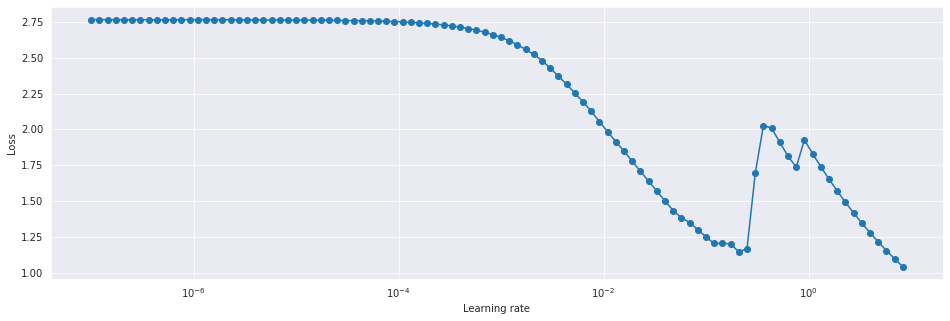

In [27]:
plot_lr_finder(lrs, losses, style='-o')

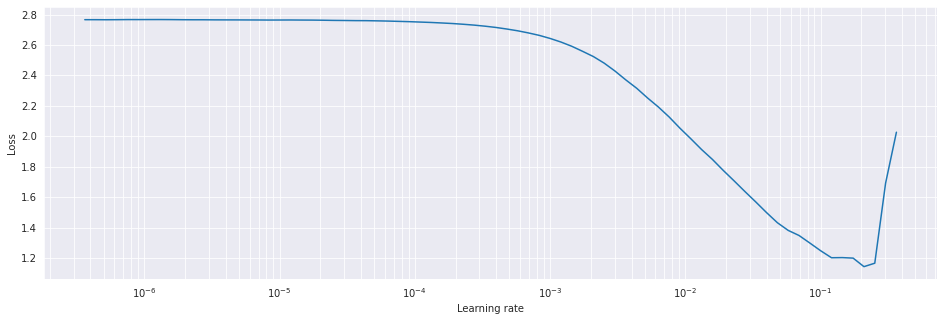

In [28]:
plot_lr_finder(lrs, losses, skip_start=7, skip_end=17)

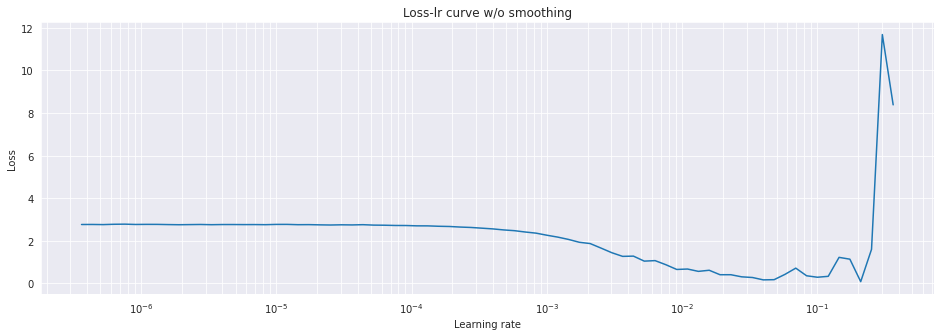

In [29]:
plot_lr_finder(lrs, lr_finder.ls, skip_start=7, skip_end=17, title='Loss-lr curve w/o smoothing')

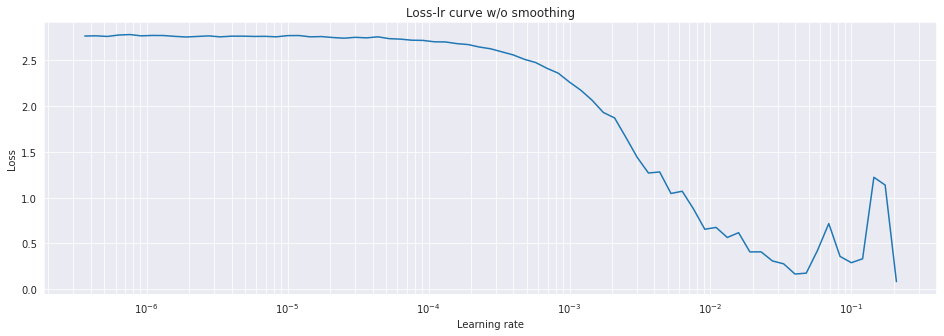

In [30]:
plot_lr_finder(lrs, lr_finder.ls, skip_start=7, skip_end=20, title='Loss-lr curve w/o smoothing')

#### Optimizer and learning rate scheduler is defined

In [31]:
FOUND_LR = 1e-1/2

optimizer = optim.SGD(model.parameters(), lr = FOUND_LR)
lrscheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=(1e-3 + 1e-2)/2., max_lr=1e-1, step_size_up=len(train_iterator))

## Training Loop 

In [32]:
%%file training_loop.py

import torch
import matplotlib.pyplot as plt

def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, 
                  hist=None, 
                  lr_scheduler=None,
                  device=torch.device('cuda')):
    best_acc = 0

    if hist is not None:
        best_acc = max(hist['vacc'])
    else:
        hist = {'tloss': [], 'tacc': [], 'vloss': [], 'vacc': []}
    #
    if lr_scheduler is not None:
        lr = [] # records lr after each epoch

    for epoch in range(1, n_epochs+1):
        tr_loss, tr_acc = 0., 0.
        n_data = 0
        model.train() # in train mode
        for im_batch, label_batch in dl_train: # minibatch
            im_batch, label_batch = im_batch.to(device), label_batch.to(device)
            ypred = model(im_batch)
            loss_train = loss_fn(ypred, label_batch)
        
            optim.zero_grad()
            loss_train.backward()
            optim.step()
            
            # accumulate correct prediction
            tr_acc  += (torch.argmax(ypred.detach(), dim=1) == label_batch).sum().item() # number of correct predictions
            tr_loss += loss_train.item() * im_batch.shape[0]
            n_data  += im_batch.shape[0]
        # end mini-batch loop
        
        # statistics
        tr_loss /= n_data
        tr_acc  /= n_data
        #
        val_loss, val_acc = performance(model, loss_fn, dl_val, device)
        
        if epoch <= 5 or epoch % 1000 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, tloss {tr_loss:.2f} t_acc: {tr_acc:.2f}  vloss {val_loss:.2f}  v_acc: {val_acc:.2f}')
        
        # best accuracy
        if best_acc < val_acc:
            best_acc = val_acc
            print(f' >> best val accuracy updated at epoch {epoch}: {best_acc}.', end='\r')
        #
        # record for history return
        if hist is not None:
            hist['tloss'].append(tr_loss); hist['vloss'].append(val_loss) 
            hist['tacc'].append(tr_acc);   hist['vacc'].append(val_acc)
            
        if lr_scheduler is not None:
            lr.append(lr_scheduler.get_lr()) # the lr used in optim.
            lr_scheduler.step()
        # end epoch-loop
        
    if lr_scheduler is not None:
        hist['lr'] = lr
        
    print ('finished training_loop().')
    return hist
#

def performance(model, loss_fn, dataloader, device=torch.device('cuda')):
    model.eval()
    with torch.no_grad():
        loss, acc, n = 0., 0., 0.
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss += loss_fn(ypred, y).item() * len(y)
            p = torch.argmax(ypred, dim=1)
            acc += (p == y).sum().item()
            n += len(y)
        #
    loss /= n
    acc /= n
    return loss, acc
#
def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(16,6))
    axes[0].set_title('Loss'); 
    axes[0].plot(history['tloss'], label='train'); axes[0].plot(history['vloss'], label='val')
    axes[0].legend()
    max_vacc = max(history['vacc'])
    axes[1].set_title(f'Acc. vbest: {max_vacc:.2f}')
    axes[1].plot(history['tacc'], label='train'); axes[1].plot(history['vacc'], label='val')
    axes[1].legend()
#

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
#


Writing training_loop.py


In [33]:
import training_loop as tx
import importlib
importlib.reload(tx)

<module 'training_loop' from '/kaggle/working/training_loop.py'>

### Perform training 

In [34]:
device = torch.device('cuda')

model = myNet(10).to(device)                            # <-- a new model, initialized
criterion = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr = FOUND_LR)  # <-- Found LR
lrscheduler = optim.lr_scheduler.CyclicLR(optimizer, 
                                          base_lr=(1e-2 + 1e-3)/2., 
                                          max_lr=1e-1, 
                                          step_size_up=len(train_iterator), 
                                          mode='exp_range',
                                          gamma=0.9)  # <-- exponentially decreasing every cycle

history = tx.training_loop(60, optimizer, model, criterion, train_iterator, valid_iterator, 
                           lr_scheduler=lrscheduler, 
                           hist=None, 
                           device=device)

Epoch 1, tloss 2.67 t_acc: 0.00  vloss 2.28  v_acc: 0.53


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:865: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch 2, tloss 2.04 t_acc: 0.75  vloss 2.15  v_acc: 0.19
Epoch 3, tloss 3.56 t_acc: 0.81  vloss 2.06  v_acc: 0.28
Epoch 4, tloss 2.54 t_acc: 0.86  vloss 2.11  v_acc: 0.25
Epoch 5, tloss 3.34 t_acc: 0.77  vloss 3.70  v_acc: 0.28
Epoch 60, tloss 0.00 t_acc: 1.00  vloss 30.85  v_acc: 0.81
finished training_loop().


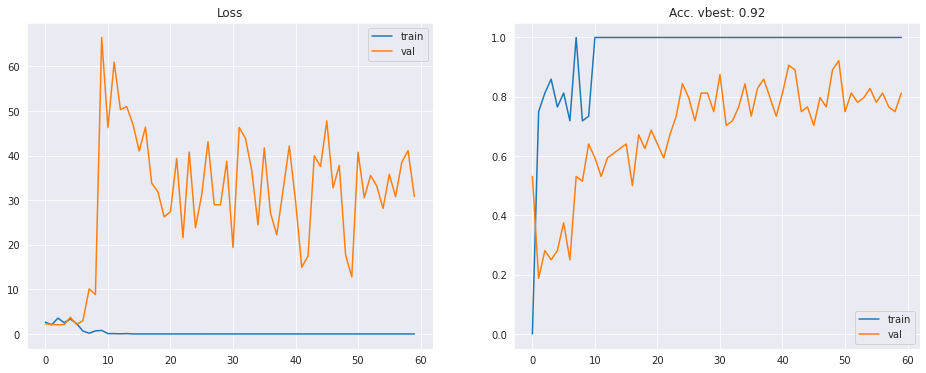

In [35]:
tx.plot_history(history)

[1.         0.9        0.81       0.729      0.6561     0.59049
 0.531441   0.4782969  0.43046721 0.38742049]


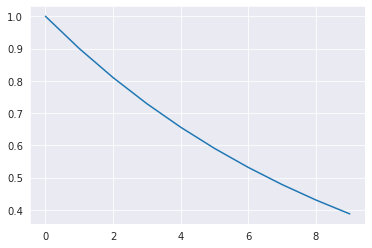

In [36]:
exp = np.power(0.9, np.arange(10, dtype=np.float))
print(exp)
plt.plot(exp)

### Visuliazing the validation result images 

Generic function to display predictions for a few images

In [37]:
N_IMAGES = 5

val_images, val_labels = zip(*[(image, label) for image, label in 
                           [val_dataset[i] for i in range(N_IMAGES)]])

classes = idx2class

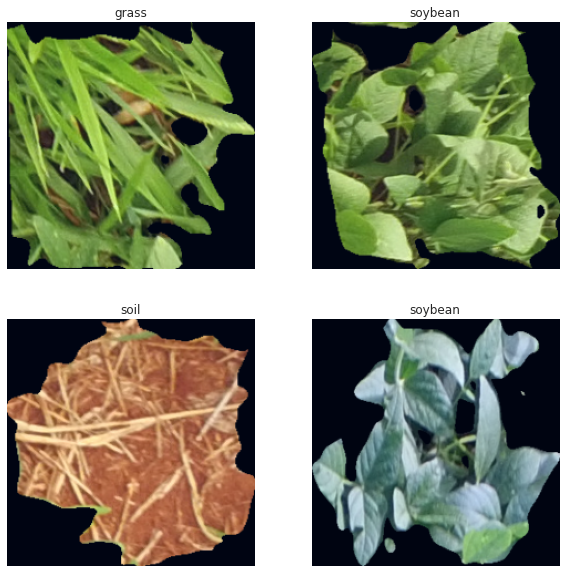

In [38]:
plot_images(val_images, val_labels, classes, normalize = True)